- **Feature Selection**: Chosen features from BRFSS 2015 are aligned with diabetes risk factors, cross-referencing the BRFSS 2015 Codebook for clarity and consistency.
  
- **Research Alignment**: The feature selection process also aligns with a study by Zidian Xie et al., focusing on machine learning for Type 2 Diabetes prediction using BRFSS 2014 data. [Research Paper Link](https://www.cdc.gov/pcd/issues/2019/19_0109.htm)

- **Codebook Reference**: For understanding BRFSS variables, the 2015 Codebook serves as a primary resource. [BRFSS 2015 Codebook Link](https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf)

- **Dependent Variable**: The main outcome variable is 'DIABETE3', capturing responses related to diabetes diagnosis, including specifics for females and pre-diabetes indications.

- **Independent Variables**: Selected variables include weight (WEIGHT2), height (HTIN4), age categories (_AGEG5YR), cholesterol status (TOLDHI2), high blood pressure diagnosis (_RFHYPE5), and general health perception (GENHLTH).

## 1. Collect/Clean the data

In [1]:
#imports
import os
import pandas as pd
import numpy as np
import random
import time

random_state = 7
random.seed(random_state)

In [2]:
def get_filenames(years):
    filenames = []
    for year in years:
        filenames.append(f'../input/behavioral-risk-factor-surveillance-system/{year}.csv')
    return filenames

In [3]:
def clean_data(filename):
    # read in .csv data
    df = pd.read_csv(filename) 
        
    # select specific columns
    #df = df[['DIABETE3','SEX','WEIGHT2','HTIN4','_RACE','_AGEG5YR','TOLDHI2','_RFHYPE5','GENHLTH']]
    #df = df[['DIABETE3','WEIGHT2','HTIN4','_AGEG5YR','TOLDHI2','_RFHYPE5','GENHLTH']]
    df = df[['DIABETE3','_BMI5','_AGEG5YR','TOLDHI2','_RFHYPE5','GENHLTH']]
    
    # drop missing values
    df = df.dropna()
    
    # 0 DIABETE3 - Diabetes
    # 1 is yes, stays yes
    # 2 gestational but i'll make it 1 (yes diabetes risk) because 50% of women with gestational go on to develop Type 2 DM, 
    # 3 is no, make it 0
    # 4 is for pre-diabetes or borderline diabetes, so make it 1 for yes diabetes risk
    # Remove all 7 (dont knows)
    # Remove all 9 (refused)
    df['DIABETE3'] = df['DIABETE3'].replace({2:1, 3:0, 4:1})
    df = df[df.DIABETE3 != 7]
    df = df[df.DIABETE3 != 9]
    
    # 2 WEIGHT2 - Weight
    # In the codebook, 7777 is don't know, 9999 is refused, 9000-9998 is metric. drop them all. 50 pounds to 999 pounds acceptable here.
    #df = df[df['WEIGHT2'].between(50, 999)]

    #3 HTIN4 - Height
    # The computer height in inches. In the codebook, 36-95 inches are acceptable based on the survey
    #df = df[df['HTIN4'].between(36, 95)]
    
    #4 _BMI5 (no changes, just note that these are BMI * 100. So for example a BMI of 4018 is really 40.18)
    df['_BMI5'] = df['_BMI5'].div(100).round(0)
    df._BMI5.unique()
    
    # 5 _AGEG5YR - Age
    # already ordinal. 1 is 18-24 all the way up to 13 wis 80 and older. 5 year increments.
    # remove 14 because it is don't know or missing
    df = df[df._AGEG5YR != 14]
    
    # 6 TOLDHI2 - HighChol
    # Change 2 to 0 because it is No
    # Remove all 7 (dont knows)
    # Remove all 9 (refused)
    df['TOLDHI2'] = df['TOLDHI2'].replace({2:0})
    df = df[df.TOLDHI2 != 7]
    df = df[df.TOLDHI2 != 9]
    
    # 7 _RFHYPE5 - HighBP
    #Change 1 to 0 so it represetnts No high blood pressure and 2 to 1 so it represents high blood pressure
    df['_RFHYPE5'] = df['_RFHYPE5'].replace({1:0, 2:1})
    df = df[df._RFHYPE5 != 9]
    
    # 8 GENHLTH - GenHlth
    # This is an ordinal variable that I want to keep (1 is Excellent -> 5 is Poor)
    # Remove 7 and 9 for don't know and refused
    df = df[df.GENHLTH != 7]
    df = df[df.GENHLTH != 9]
    
    #Rename the columns to make them more readable
    df = df.rename(columns = {'DIABETE3':'Diabetes_risk', 
                              #'WEIGHT2':'Weight',
                              #'HTIN4':'Height',
                              '_BMI5':'BMI',
                              '_AGEG5YR':'Age',
                              'TOLDHI2':'HighChol',
                              '_RFHYPE5':'HighBP',
                              'GENHLTH':'GenHlth'})
    
    return df

In [4]:
#select years to include
years = ['2015']

# merge all the years of BRFSS .csv data
df = pd.concat(map(clean_data, get_filenames(years)), ignore_index=True)
df.shape

(344940, 6)

**At this point we have 344,940 records and 6 columns. Each record contains an individual's BRFSS survey responses.**

In [5]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df, title='Diabetes Data Profile')
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 2. Basic data description

In [6]:
df.describe()

,Diabetes_risk,BMI,Age,HighChol,HighBP,GenHlth
count,344940.000000,344940.000000,344940.000000,344940.000000,344940.000000,344940.000000
mean,0.171186,28.226631,8.240372,0.426935,0.441807,2.572163
std,0.376672,6.602288,3.151097,0.494633,0.496603,1.090519
min,0.000000,12.000000,1.000000,0.000000,0.000000,1.000000
25%,0.000000,24.000000,6.000000,0.000000,0.000000,2.000000
50%,0.000000,27.000000,9.000000,0.000000,0.000000,2.000000
75%,0.000000,31.000000,11.000000,1.000000,1.000000,3.000000
max,1.000000,98.000000,13.000000,1.000000,1.000000,5.000000


In [ ]:
df.info()

In [7]:
for col in df:
    print(f'{col} unique values= {np.sort(df[col].unique())}')

Diabetes_risk unique values= [0. 1.]
BMI unique values= [12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.
 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.
 48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65.
 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83.
 84. 85. 86. 87. 88. 89. 90. 91. 92. 95. 96. 97. 98.]
Age unique values= [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]
HighChol unique values= [0. 1.]
HighBP unique values= [0. 1.]
GenHlth unique values= [1. 2. 3. 4. 5.]


In [8]:
#Check how many respondents have no diabetes, prediabetes or diabetes. Note the class imbalance!
df.groupby(['Diabetes_risk']).size()

Diabetes_risk
0.0    285891
1.0     59049
dtype: int64

In [9]:
#Separate the 0(No Diabetes) and 1(Pre-diabetes and Diabetes)
#Get the 1s
is1 = df['Diabetes_risk'] == 1
df_1 = df[is1]

#Get the 0s
is0 = df['Diabetes_risk'] == 0
df_0 = df[is0] 

#Select the 39977 random cases from the 0 (non-diabetes group). we already have 58949 cases from the diabetes risk group
df_0_rand1 = df_0.take(np.random.permutation(len(df_0))[:58949])

#Append the 39977 1s to the 39977 randomly selected 0s
df_balanced = df_0_rand1.append(df_1, ignore_index = True)

In [10]:
df_balanced.head()

,Diabetes_risk,BMI,Age,HighChol,HighBP,GenHlth
0,0.0,27.0,10.0,1.0,0.0,2.0
1,0.0,36.0,4.0,0.0,0.0,2.0
2,0.0,28.0,12.0,0.0,1.0,2.0
3,0.0,22.0,8.0,1.0,0.0,1.0
4,0.0,27.0,11.0,0.0,0.0,3.0


In [11]:
df_balanced.groupby(['Diabetes_risk']).size()

Diabetes_risk
0.0    58949
1.0    59049
dtype: int64

## 3. Save to csv
First save version where diabetes is the target variable and in the first column. This is the full cleaned dataset with prediabetes still there.

In [12]:
#************************************************************************************************
df.to_csv('diabetes_risk.csv', sep=",", index=False)
df_balanced.to_csv('diabetes_risk_balanced.csv', sep=",", index=False)
#************************************************************************************************

## 4. Model Building
* simple random forest because it can handle the categorical race variable without needing to dummy. 

In [13]:
pip install pydotplus

     |████████████████████████████████| 278 kB 6.3 MB/s eta 0:00:01
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24575 sha256=0b669a96a0b6a5e0f6ae4b7634fd0c72992bb9cd0de6ef0899a6e4a50a7d02ae
  Stored in directory: /root/.cache/pip/wheels/1e/7b/04/7387cf6cc9e48b4a96e361b0be812f0708b394b821bf8c9c50
Successfully built pydotplus
Note: you may need to restart the kernel to use updated packages.


In [16]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz
import graphviz
import pydotplus
from IPython.display import Image 

from sklearn.metrics import confusion_matrix, make_scorer, classification_report

In [17]:
df_balanced.head()

,Diabetes_risk,BMI,Age,HighChol,HighBP,GenHlth
0,0.0,27.0,10.0,1.0,0.0,2.0
1,0.0,36.0,4.0,0.0,0.0,2.0
2,0.0,28.0,12.0,0.0,1.0,2.0
3,0.0,22.0,8.0,1.0,0.0,1.0
4,0.0,27.0,11.0,0.0,0.0,3.0


In [19]:
#select HeartDiseaseorAttack as target variable:
y = df_balanced['Diabetes_risk']

#select all the other columns minus HeartDiseaseorAttack as the feature variables:
X = df_balanced.drop(['Diabetes_risk'],axis=1)

In [20]:
#now make the train-test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state=random_state)
print('Dimensions: \n x_train:{} \n x_test{} \n y_train{} \n y_test{}'.format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))

Dimensions: 
 x_train:(100298, 5) 
 x_test(17700, 5) 
 y_train(100298,) 
 y_test(17700,)


In [21]:
X_test

,BMI,Age,HighChol,HighBP,GenHlth
33238,33.0,6.0,1.0,1.0,3.0
73115,27.0,7.0,1.0,1.0,5.0
24610,29.0,10.0,1.0,1.0,4.0
56154,30.0,11.0,1.0,1.0,1.0
15559,27.0,4.0,0.0,0.0,3.0
...,...,...,...,...,...
68393,37.0,12.0,1.0,1.0,3.0
69933,25.0,10.0,1.0,1.0,2.0
45604,26.0,1.0,0.0,0.0,2.0
13586,26.0,9.0,0.0,1.0,1.0


In [22]:
#create true negative, false positive, false negative, and true positive 
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

In [23]:
#Setup classifier scorers
scorers = {'Accuracy': 'accuracy', 
           'roc_auc': 'roc_auc', 
           'Sensitivity':'recall', 
           'precision':'precision',
            'tp': make_scorer(tp), 
           'tn': make_scorer(tn),
           'fp': make_scorer(fp), 
           'fn': make_scorer(fn)}   

### DT

In [24]:
#change this name here to change the print name
classifier_name = 'DT: '

start_ts = time.time()
#try swapping out the classifier for a different one or changing the parameters
clf = DecisionTreeClassifier(max_depth = 3, min_samples_split=500, criterion='entropy',random_state=random_state)
scores = cross_validate(clf, X, y, scoring=scorers, cv=5)          

Sensitivity = round(scores['test_tp'].mean() / (scores['test_tp'].mean() + scores['test_fn'].mean()),3)*100   #TP/(TP+FN) also recall
Specificity = round(scores['test_tn'].mean() / (scores['test_tn'].mean() + scores['test_fp'].mean()),3)*100    #TN/(TN+FP)
PPV = round(scores['test_tp'].mean() / (scores['test_tp'].mean() + scores['test_fp'].mean()),3)*100           #PPV = tp/(tp+fp) also precision
NPV = round(scores['test_tn'].mean() / (scores['test_fn'].mean() + scores['test_tn'].mean()),3)*100           #TN(FN+TN)

scores_Acc = scores['test_Accuracy']                                                                                                                                    
print(f"{classifier_name} Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                    
scores_AUC = scores['test_roc_auc']                                                                     #Only works with binary classes, not multiclass                  
print(f"{classifier_name} AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))      
scores_sensitivity = scores['test_Sensitivity']                                                                     #Only works with binary classes, not multiclass                  
print(f"{classifier_name} Recall/Sensitivity: %0.2f (+/- %0.2f)" % (scores_sensitivity.mean(), scores_sensitivity.std() * 2)) 
scores_precision = scores['test_precision']                                                                     #Only works with binary classes, not multiclass                  
print(f"{classifier_name} Precision/PPV: %0.2f (+/- %0.2f)" % (scores_precision.mean(), scores_precision.std() * 2))                          
print(f"{classifier_name} Specificity = ", round(Specificity,2), "%") 
print(f"{classifier_name} NPV = ", round(NPV,2), "%")

print("Runtime:", round(time.time()-start_ts,2), 'seconds')

DT:  Acc: 0.70 (+/- 0.02)
DT:  AUC: 0.76 (+/- 0.02)
DT:  Recall/Sensitivity: 0.75 (+/- 0.02)
DT:  Precision/PPV: 0.68 (+/- 0.01)
DT:  Specificity =  65.2 %
DT:  NPV =  72.3 %
Runtime: 1.38 seconds


In [25]:
#train the decision tree
dt = DecisionTreeClassifier(max_depth = 3, min_samples_split=500, random_state=random_state)
dt.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=3, min_samples_split=500, random_state=7)

In [26]:
# Export graphviz object from the trained decision tree 
exported = export_graphviz(decision_tree = dt, 
    # Assign feature names
    out_file=None, feature_names=X_train.columns, 
    # Set precision to 1 and add class names
     precision=1, class_names=['No Diabetes','Diabetes'], filled = True)

# Call the Source function and pass the exported graphviz object
#graph = graphviz.Source(exported)
graph = pydotplus.graph_from_dot_data(exported)  
graph.write_png("Decision Tree Rules.png")

True

In [27]:
ls

'Decision Tree Rules.png'   diabetes_risk.csv   diabetes_risk_balanced.csv


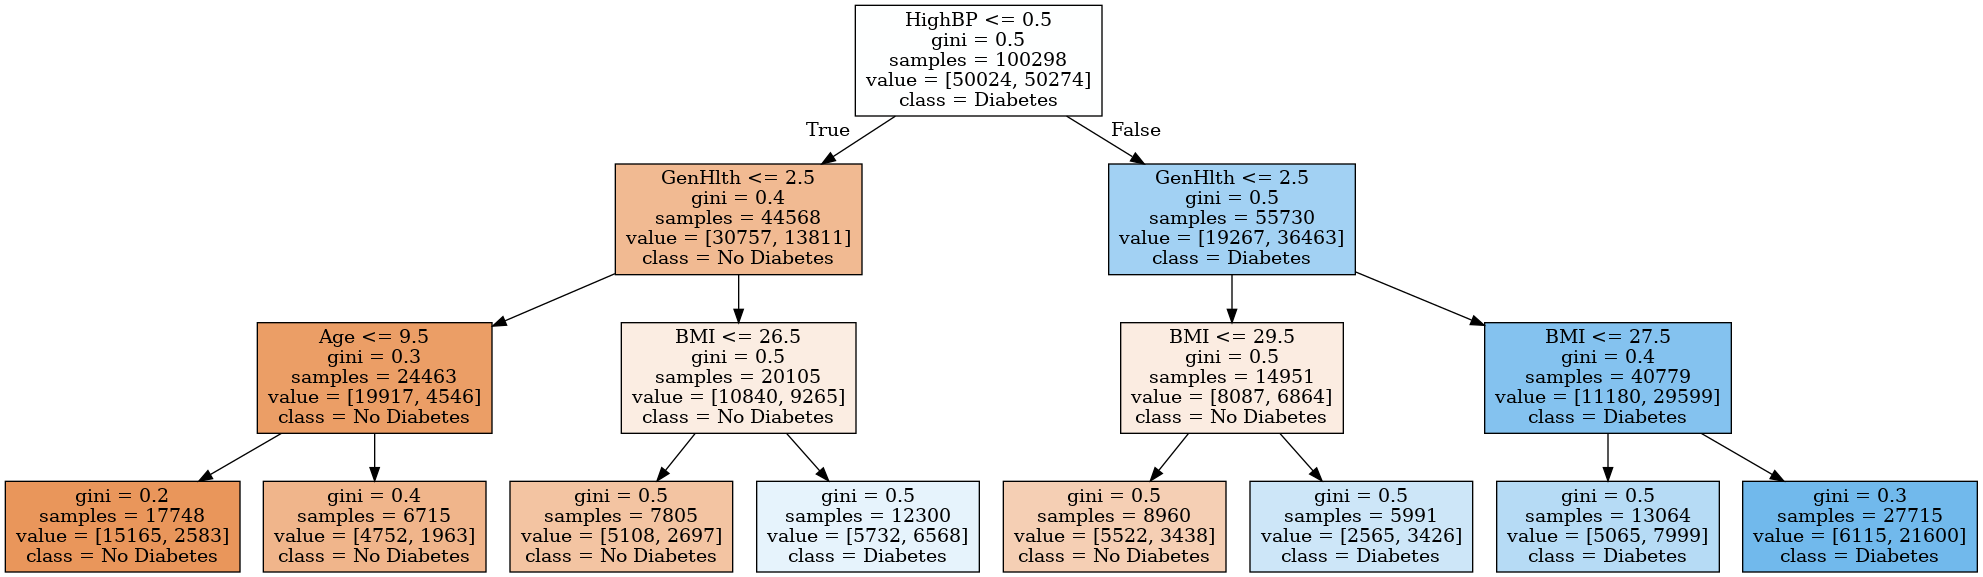

In [28]:
Image('./Decision Tree Rules.png')

In [29]:
y_pred = dt.predict(X_test)

In [30]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[5457 3468]
 [1882 6893]]
              precision    recall  f1-score   support

         0.0       0.74      0.61      0.67      8925
         1.0       0.67      0.79      0.72      8775

    accuracy                           0.70     17700
   macro avg       0.70      0.70      0.70     17700
weighted avg       0.70      0.70      0.70     17700



### Saving the Model

In [32]:
!pip install joblib==1.1.0

import joblib
joblib.dump(dt, 'dt_model.pkl') 

     |████████████████████████████████| 306 kB 6.5 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.0.1
    Uninstalling joblib-1.0.1:
      Successfully uninstalled joblib-1.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.4.3 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.23.2 which is incompatible.


['dt_model.pkl']

* Now that we have our model saved, image of the model structure, and data saved to .csv we're ready to go into VS Code and code up the streamlit app itself.